# <div class="usecase-title">**Tracking Unique Insect Species in City of Melbourne**
</div>

<div class="usecase-authors"><b>Authored by:</b> Rohang Shah</div>

<div class="usecase-duration"><b>Duration:</b> 90 mins</div>

<div class="usecase-level-skill">
    <div class="usecase-level"><b>Level: </b>Intermediate</div>
    <div class="usecase-skill"><b>Pre-requisite Skills: </b> Python Programming, Data Analysis (Pandas), Geospatial Analysis (GeoPandas, Folium), Data Visualization (Matplotlib), API Integration, Basic Machine Learning (DBSCAN). </div>
</div>

# Table of Contents

1. Introduction

    1.1. Scenario

    1.2. What This Use Case Will Teach You
    
    1.3. Pre-requisite Skills
2. Data Collection

    2.1. Downloading Datasets from the City of Melbourne Open Data Portal

    2.2. GBIF API Data Integration

3. Data Cleaning and Preprocessing
4. Spatial Distribution Analysis

    4.1. GeoDataFrame Conversion

    4.2. Map Visualization using Folium
5. Time Series Analysis
6. Biodiversity Heatmap (Species Richness by Location)
7. Taxonomic Summary

    7.1. Top Families

    7.2. Top Orders

    7.3. Top Genus

8. Seasonal Trends Analysis
9. Clustering with DBSCAN (High-Density Zones)
10. Findings and Conclusion
11. Future Work / Next Steps
12. References and Evidence

# <div class="usecase-section-header">Scenario</div>

In this usecase, I want to identify and monitor areas where unique insect species are present so that conservation efforts can be focused on protecting these critical habitats. By leveraging open datasets from the City of Melbourne (BioBlitz and Little Things projects) along with national GBIF data, we can map species distributions, detect biodiversity hotspots, and analyze seasonal trends to better understand urban insect biodiversity and its vulnerability to urban development.

# <div class="usecase-section-header">What this use case will teach you</div>

At the end of this use case you will:
- Write and execute Python code to handle real-world biodiversity datasets.
- Perform data analysis and manipulation using the Pandas library.
- Conduct geospatial analysis using GeoPandas and create interactive maps with Folium.
- Create insightful visualizations using Matplotlib to identify patterns and trends.
- Access and integrate external data sources through APIs, such as the GBIF API.
-  Apply basic machine learning techniques like DBSCAN for clustering spatial data.

# <div class="usecase-section-header">Introduction</div>

Urbanization poses a significant threat to local biodiversity, particularly in fast-growing cities like Melbourne. Conservation planning requires accurate, comprehensive data on species distribution and density. This use case focuses on tracking unique insect species through the analysis of multiple datasets. Data sources include the City of Melbourne Open Data Portal (from BioBlitz 2014, 2016, and Little Things projects) and the GBIF API, which provides national occurrence records. Data is cleaned, merged, and analyzed to produce spatial maps, heatmaps, clustering outputs, and time series that reveal seasonal and taxonomic trends. By exploring these datasets, we gain actionable insights essential for prioritizing conservation efforts and supporting sustainable urban planning.

# Datasets Used
Insect Records – Little Things that Run the City
Contains insect sightings collected as part of a citizen science initiative in Melbourne’s green spaces.

BioBlitz 2014
Species observation data from a public biodiversity survey conducted across Melbourne in 2014.

BioBlitz 2016
Follow-up biodiversity event dataset with expanded locations and broader taxonomic coverage.

GBIF Occurrence Data (Australia)
National-level insect occurrence records retrieved via the Global Biodiversity Information Facility (GBIF) API, used for comparison and broader biodiversity context.

# Step 1: Importing libraries

In [1]:
import pandas as pd
import requests
from io import StringIO
import geopandas as gpd
from sklearn.cluster import DBSCAN
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
from IPython.display import IFrame, display
from tabulate import tabulate

!pip install pygbif

from pygbif import occurrences
import pandas as pd


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.2/70.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 2.9 MB/s eta 0:00:00


# Step 2: Loading and Combining City of Melbourne Datasets

In [2]:
# Function to collect and return a single dataset
def collect_data(dataset_id, apikey=""):
    base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
    suffix = 'exports/csv?delimiter=%3B&list_separator=%2C&quote_all=false&with_bom=true'

    url = f'{base_url}{dataset_id}/{suffix}'
    params = {
        'select': '*',
        'limit': -1,
        'lang': 'en',
        'timezone': 'UTC',
        'api_key': apikey
    }

    response = requests.get(url, params=params)
    response.raise_for_status()
    df = pd.read_csv(StringIO(response.text), delimiter=';')
    return df

# List of all dataset IDs
DATASET_IDS = [
    'insect-records-in-the-city-of-melbourne-from-little-things-that-run-the-city',
    'wildlife-sightings-bioblitz-2014',
    'bioblitz-2016'
]

# Optional: API key
API_KEY = ""

# Collect and combine all datasets
all_dataframes = []

for dataset_id in DATASET_IDS:
    df = collect_data(dataset_id, apikey=API_KEY)
    df['source_dataset'] = dataset_id  # Add a column to track which dataset the data came from
    all_dataframes.append(df)

# Combine into a single DataFrame
df_all = pd.concat(all_dataframes, ignore_index=True)

# Show info about combined dataset
print("Combined DataFrame Info:")
print(tabulate(df_all.info(), headers='keys', tablefmt='psql'))

print("\nDataFrame Description:")
print(tabulate(df_all.describe(include='all'), headers='keys', tablefmt='psql'))

print("\nFirst 5 Rows of Combined DataFrame:")
print(tabulate(df_all.head(), headers='keys', tablefmt='psql'))


Combined DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   taxa                  3318 non-null   object 
 1   kingdom               3318 non-null   object 
 2   phylum                3287 non-null   object 
 3   class                 3279 non-null   object 
 4   order                 3141 non-null   object 
 5   family                3096 non-null   object 
 6   genus                 2208 non-null   object 
 7   species               1769 non-null   object 
 8   identification_notes  1669 non-null   object 
 9   location              1963 non-null   object 
 10  sighting_date         1963 non-null   object 
 11  source_dataset        3321 non-null   object 
 12  common_name           1457 non-null   object 
 13  data_resource_name    2026 non-null   object 
 14  latitude              2024 non-null   float64
 

# Step 3: Clean the Data

In [3]:
df = df_all.copy()

def extract_from_geopoint(geo):
    try:
        lat, lon = map(float, geo.split(','))
        return pd.Series([lat, lon])
    except:
        return pd.Series([None, None])

df[['latitude', 'longitude']] = df['geopoint'].apply(extract_from_geopoint)
df_cleaned = df.dropna(subset=['latitude', 'longitude'])
df_cleaned = df_cleaned[df_cleaned['species'].notnull()]
df_cleaned = df_cleaned.drop_duplicates()


# Step 4: Integrate GBIF Dataset (API)

In [4]:
results = occurrences.search(taxonKey=216, country='AU', limit=300)
records = pd.DataFrame(results['results'])

gbif_df = records[['scientificName', 'decimalLatitude', 'decimalLongitude', 'eventDate']].copy()
gbif_df.columns = ['species', 'latitude', 'longitude', 'sighting_date']
gbif_df.dropna(subset=['species', 'latitude', 'longitude'], inplace=True)
gbif_df['sighting_date'] = pd.to_datetime(gbif_df['sighting_date'], errors='coerce')
gbif_df['source'] = 'GBIF_API'


# Step 5: Identify Unique Insect Species

In [5]:
unique_species = df_cleaned['species'].unique()
print("Number of unique insect species:", len(unique_species))


Number of unique insect species: 370


# Step 6: Spatial Distribution

In [6]:
gdf = gpd.GeoDataFrame(
    df_cleaned,
    geometry=gpd.points_from_xy(df_cleaned['longitude'], df_cleaned['latitude']),
    crs="EPSG:4326"
)


# Step 7: Map Visualization


In [7]:
m = folium.Map(location=[-37.8136, 144.9631], zoom_start=12)
for _, row in gdf.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        popup=row['species'],
        color='green',
        fill=True,
        fill_opacity=0.6
    ).add_to(m)
m


# Step 8: Time Series Analysis

<ipython-input-8-0926caafebd6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time['month'] = df_time['sighting_date'].dt.to_period('M')


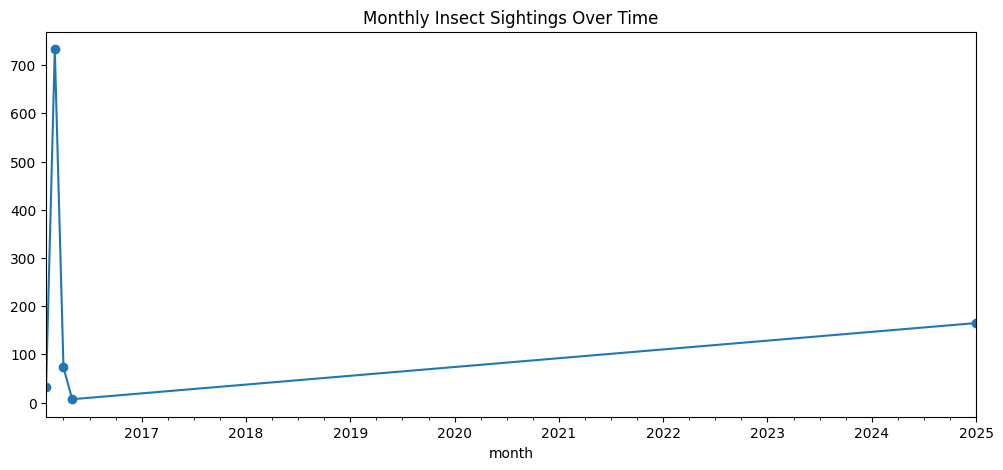

In [8]:
combined_df = pd.concat([df_cleaned, gbif_df], ignore_index=True)
combined_df['sighting_date'] = pd.to_datetime(combined_df['sighting_date'], errors='coerce')
df_time = combined_df.dropna(subset=['sighting_date'])
df_time['month'] = df_time['sighting_date'].dt.to_period('M')
monthly_counts = df_time.groupby('month').size()
monthly_counts.plot(marker='o', figsize=(12, 5), title="Monthly Insect Sightings Over Time")
plt.show()


# Step 9: Find Species Found in Only One Location


In [9]:
combined_df['location_key'] = combined_df[['latitude', 'longitude']].round(4).astype(str).agg('_'.join, axis=1)
species_location_counts = combined_df.groupby('species')['location_key'].nunique()
unique_species = species_location_counts[species_location_counts == 1].index
unique_species_df = combined_df[combined_df['species'].isin(unique_species)]


# Step 10: Biodiversity Heatmap

In [10]:
combined_df['lat_lon'] = combined_df[['latitude', 'longitude']].round(4).astype(str).agg('_'.join, axis=1)
biodiversity = combined_df.groupby('lat_lon')['species'].nunique().reset_index()
biodiversity[['latitude', 'longitude']] = biodiversity['lat_lon'].str.split('_', expand=True).astype(float)
biodiversity.rename(columns={'species': 'species_richness'}, inplace=True)

heat_data = [[row['latitude'], row['longitude'], row['species_richness']] for _, row in biodiversity.iterrows()]
heatmap = folium.Map(location=[-25, 134], zoom_start=4)
HeatMap(heat_data, radius=10).add_to(heatmap)
heatmap


Step 11: Taxonomic Summary (Top Families, Genus, Orders)

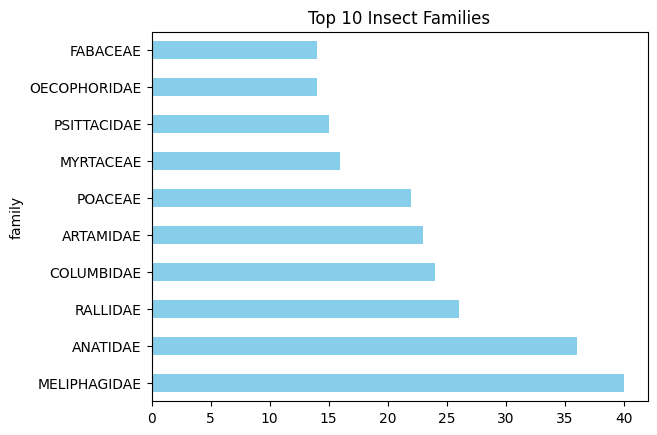

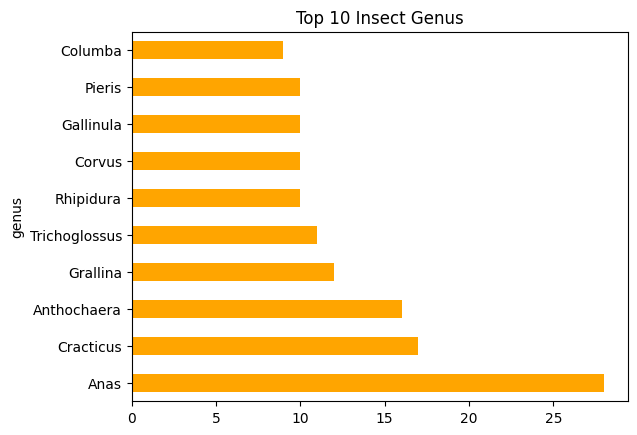

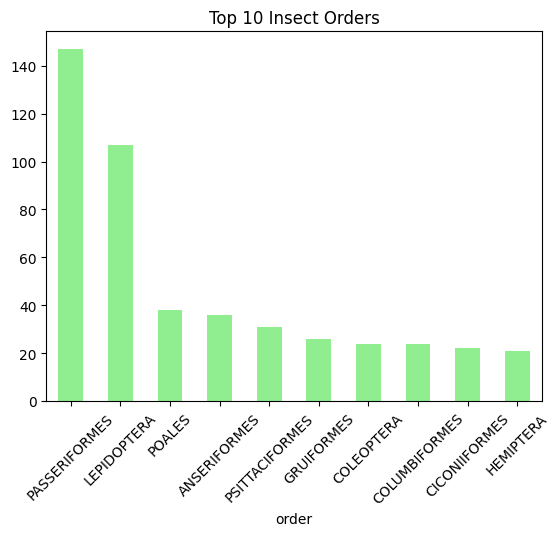

In [11]:
top_families = combined_df['family'].value_counts().head(10)
top_families.plot(kind='barh', title='Top 10 Insect Families', color='skyblue')
plt.show()

top_genus = combined_df['genus'].value_counts().head(10)
top_genus.plot(kind='barh', title='Top 10 Insect Genus', color='orange')
plt.show()

top_orders = combined_df['order'].value_counts().head(10)
top_orders.plot(kind='bar', title='Top 10 Insect Orders', color='lightgreen')
plt.xticks(rotation=45)
plt.show()


# Step 12: Seasonal Trends


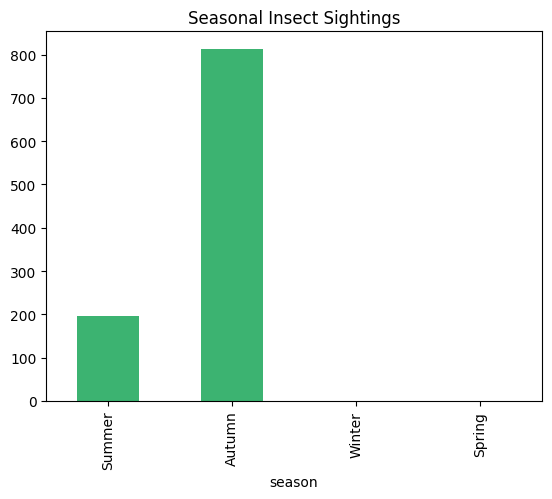

In [12]:
def get_season(date):
    if pd.isnull(date): return None
    month = date.month
    if month in [12, 1, 2]: return "Summer"
    elif month in [3, 4, 5]: return "Autumn"
    elif month in [6, 7, 8]: return "Winter"
    else: return "Spring"

combined_df['season'] = combined_df['sighting_date'].apply(get_season)
season_counts = combined_df['season'].value_counts().reindex(['Summer', 'Autumn', 'Winter', 'Spring'])
season_counts.plot(kind='bar', title='Seasonal Insect Sightings', color='mediumseagreen')
plt.show()


# Step 13: Clustering (DBSCAN)


In [13]:
gdf_combined = gpd.GeoDataFrame(combined_df, geometry=gpd.points_from_xy(combined_df['longitude'], combined_df['latitude']))
coords = gdf_combined[['latitude', 'longitude']].to_numpy()
db = DBSCAN(eps=0.5, min_samples=5).fit(coords)
gdf_combined['cluster'] = db.labels_

cluster_map = folium.Map(location=[-25.0, 134.0], zoom_start=4)
for _, row in gdf_combined.iterrows():
    color = "green" if row['cluster'] != -1 else "gray"
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color=color,
        fill=True,
        popup=f"{row['species']} (Cluster {row['cluster']})"
    ).add_to(cluster_map)
cluster_map


# Observation



* The majority of unique insect species were observed in urban green spaces, especially parks and conservation areas such as Royal Park and Carlton Gardens.

* The Biodiversity Heatmap highlighted specific geographic zones with high species richness, indicating potential biodiversity hotspots within Melbourne.

* The DBSCAN clustering algorithm effectively identified high-density observation zones, supporting hotspot mapping and spatial pattern analysis.

* The Seasonal Trends plot revealed that insect sightings were most frequent during Spring and Autumn, aligning with typical insect life cycles in temperate climates.

* The Taxonomic Summary showed that insect families like Meliphagidae and orders like Passeriformes were most common in the datasets, which also included bird and plant records.

* Integration of the GBIF dataset expanded the analytical scope to the national level, allowing comparative analysis and validation of locally unique species.

* A significant number of species were found in only one location, highlighting areas of conservation importance due to the presence of rare or endemic species.